In [1]:
%load_ext autoreload
%autoreload 2

In [90]:
from transduction import examples, Precover, FSA, FST, EPSILON
from transduction.peekaboo_recursive import PeekabooState, Peekaboo
import transduction.peekaboo_recursive
from transduction.util import display_table
from graphviz import Digraph
from transduction.eager_nonrecursive import is_universal

In [148]:
def compare(prev, curr):
    _prev = prev
    _curr = curr
    curr = curr.det.materialize()  #.trim()
    prev = prev.det.materialize()  #.trim()

    _prev_universal_states = {i for i in prev.stop if is_universal(prev, i, _prev.source_alphabet)}
    _curr_universal_states = {i for i in curr.stop if is_universal(curr, i, _curr.source_alphabet)}
    
    curr = FSA(
        start = curr.start,
        stop = curr.stop,
        arcs = [(i,x,j) for i in curr.states - _curr_universal_states for x,j in curr.arcs(i)],
    )
    prev = FSA(
        start = prev.start,
        stop = prev.stop,
        arcs = [(i,x,j) for i in prev.states - _prev_universal_states for x,j in prev.arcs(i)],
    )   

    removed_nodes = set()
    print('# nodes', colors.line(80))
    for i in sorted(prev.states - curr.states):   # remove
        print(colors.light.red % '├─ remove:', i)
        removed_nodes.add(i)
    for i in sorted(curr.states - prev.states):   # add
        print(colors.light.green % '├─ add:   ', i)
    for i in sorted(curr.states & prev.states):   # copy
        print(colors.light.yellow % '├─ copy:  ', i)

    prev_arcs = set(prev.arcs())
    curr_arcs = set(curr.arcs())
    
    print('# edges', colors.line(80))
    for (i,x,j) in sorted(prev_arcs - curr_arcs):
        if i in removed_nodes or j in removed_nodes: continue
        print(colors.light.red % '├─ remove:', (i,x,j))
    for (i,x,j) in sorted(curr_arcs - prev_arcs):
        print(colors.light.green % '├─ add:   ', (i,x,j))
    for (i,x,j) in sorted(curr_arcs & prev_arcs):
        print(colors.light.yellow % '├─ copy:  ', (i,x,j))


In [149]:
def rollout(fst, target):
    N = len(target)
    print(colors.bold % repr(''))
    prev = Precover(fst, '')
    display(prev)
    for n in range(1, N+1):
        print(colors.bold % repr(target[:n]))
        curr = Precover(fst, target[:n])
        compare(prev, curr)
        display(curr)
        prev = curr

### abc

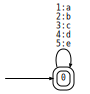

In [150]:
fst = examples.replace([('1', 'a'), ('2', 'b'), ('3', 'c'), ('4', 'd'), ('5', 'e')])
#Peekaboo(fst).graphviz('abc')
fst

''


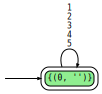

'a'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ add:    {(0, 'a')}
├─ copy:   {(0, '')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(0, '')}, '1', {(0, 'a')})


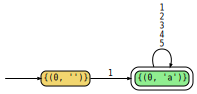

'ab'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ add:    {(0, 'ab')}
├─ copy:   {(0, '')}
├─ copy:   {(0, 'a')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(0, 'a')}, '2', {(0, 'ab')})
├─ copy:   ({(0, '')}, '1', {(0, 'a')})


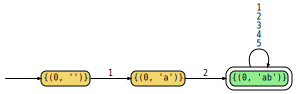

'abc'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ add:    {(0, 'abc')}
├─ copy:   {(0, '')}
├─ copy:   {(0, 'a')}
├─ copy:   {(0, 'ab')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(0, 'ab')}, '3', {(0, 'abc')})
├─ copy:   ({(0, '')}, '1', {(0, 'a')})
├─ copy:   ({(0, 'a')}, '2', {(0, 'ab')})


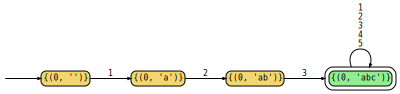

In [151]:
rollout(fst, 'abc')

### Parity

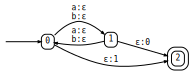

In [152]:
fst = examples.parity({'a', 'b'})
fst

'1'
''


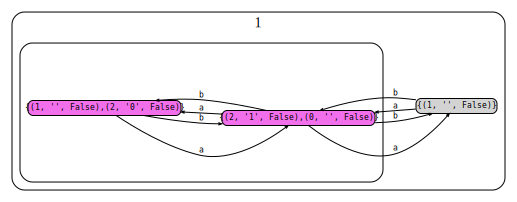

In [153]:
Peekaboo(fst).graphviz('1')

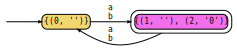

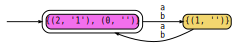

quotient,remainder
∅,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 1 <!-- start->0 --> start->0 <!-- 1 --> 1 0 <!-- 0->1 --> 0->1 a b <!-- 1->0 --> 1->0 a b"


quotient,remainder
∅,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 0 <!-- start->0 --> start->0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 a b <!-- 1->0 --> 1->0 a b"


In [154]:
display(Precover(fst, '0'))
display(Precover(fst, '1'))
Precover(fst, '0').show_decomposition()
Precover(fst, '1').show_decomposition()

### Samuel's machine

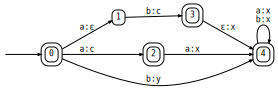

In [155]:
fst = examples.samuel_example()
#Peekaboo(fst).graphviz('cxx')
fst

''


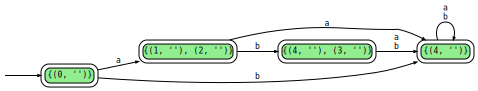

'c'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(4, ''),(3, '')}
├─ remove: {(1, ''),(2, '')}
├─ remove: {(4, '')}
├─ add:    {(3, 'c'),(4, 'c')}
├─ add:    {(1, ''),(2, 'c')}
├─ add:    {(4, 'c')}
├─ copy:   {(0, '')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(0, '')}, 'a', {(1, ''),(2, 'c')})


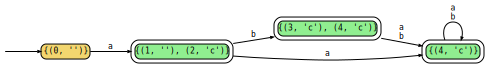

'cx'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(4, 'c')}
├─ remove: {(3, 'c'),(4, 'c')}
├─ add:    {(4, 'cx')}
├─ add:    {(4, 'cx'),(3, 'c')}
├─ copy:   {(0, '')}
├─ copy:   {(1, ''),(2, 'c')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(1, ''),(2, 'c')}, 'a', {(4, 'cx')})
├─ add:    ({(1, ''),(2, 'c')}, 'b', {(4, 'cx'),(3, 'c')})
├─ copy:   ({(0, '')}, 'a', {(1, ''),(2, 'c')})


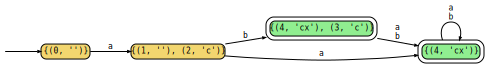

'cxx'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ add:    {(4, 'cxx')}
├─ copy:   {(0, '')}
├─ copy:   {(1, ''),(2, 'c')}
├─ copy:   {(4, 'cx')}
├─ copy:   {(4, 'cx'),(3, 'c')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(4, 'cx')}, 'a', {(4, 'cxx')})
├─ add:    ({(4, 'cx')}, 'b', {(4, 'cxx')})
├─ add:    ({(4, 'cx'),(3, 'c')}, 'a', {(4, 'cxx')})
├─ add:    ({(4, 'cx'),(3, 'c')}, 'b', {(4, 'cxx')})
├─ copy:   ({(1, ''),(2, 'c')}, 'a', {(4, 'cx')})
├─ copy:   ({(1, ''),(2, 'c')}, 'b', {(4, 'cx'),(3, 'c')})
├─ copy:   ({(0, '')}, 'a', {(1, ''),(2, 'c')})


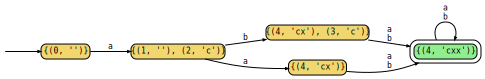

'cxxx'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ add:    {(4, 'cxxx')}
├─ copy:   {(4, 'cx'),(3, 'c')}
├─ copy:   {(0, '')}
├─ copy:   {(1, ''),(2, 'c')}
├─ copy:   {(4, 'cx')}
├─ copy:   {(4, 'cxx')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(4, 'cxx')}, 'a', {(4, 'cxxx')})
├─ add:    ({(4, 'cxx')}, 'b', {(4, 'cxxx')})
├─ copy:   ({(1, ''),(2, 'c')}, 'a', {(4, 'cx')})
├─ copy:   ({(1, ''),(2, 'c')}, 'b', {(4, 'cx'),(3, 'c')})
├─ copy:   ({(4, 'cx')}, 'a', {(4, 'cxx')})
├─ copy:   ({(4, 'cx')}, 'b', {(4, 'cxx')})
├─ copy:   ({(4, 'cx'),(3, 'c')}, 'b', {(4, 'cxx')})
├─ copy:   ({(0, '')}, 'a', {(1, ''),(2, 'c')})
├─ copy:   ({(4, 'cx'),(3, 'c')}, 'a', {(4, 'cxx')})


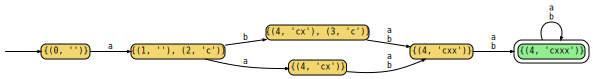

In [156]:
rollout(fst, 'cxxx')

'cxxx'
'cxx'
'cx'
'c'
''


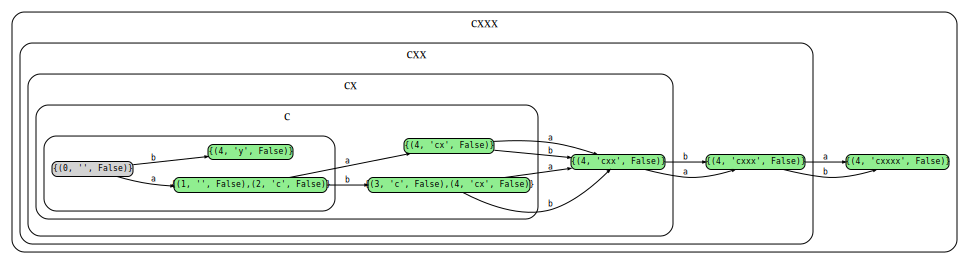

In [157]:
Peekaboo(fst).graphviz('cxxx')

### Infinite quotient

'1'
''


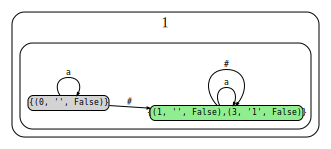

In [158]:
fst = examples.infinite_quotient()
Peekaboo(fst).graphviz('1')

In [159]:
Precover(fst, '1').show_decomposition()

quotient,remainder
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 2 <!-- start->0 --> start->0 <!-- 0->0 --> 0->0 a <!-- 1 --> 1 0 <!-- 0->1 --> 0->1 #",∅


### Dupicate (K=2)

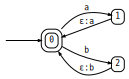

In [160]:
fst = examples.duplicate('ab').renumber
fst

'aabba'
'aabb'
'aab'
'aa'
'a'
''


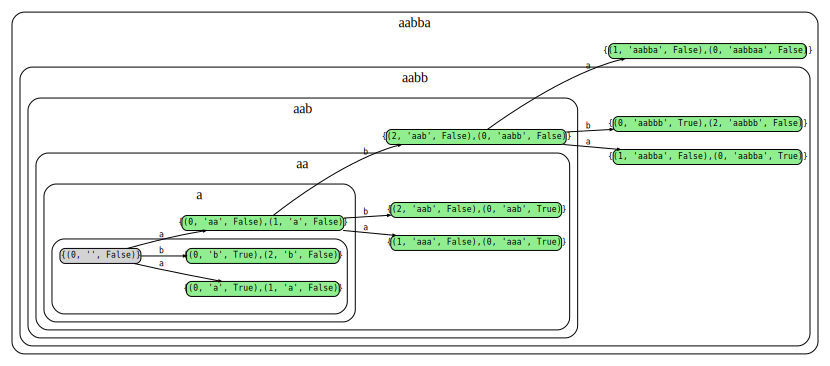

In [161]:
Peekaboo(fst).graphviz('aabba')

### Duplicate (K=4)

'aaaabbbba'
'aaaabbbb'
'aaaabbb'
'aaaabb'
'aaaab'
'aaaa'
'aaa'
'aa'
'a'
''


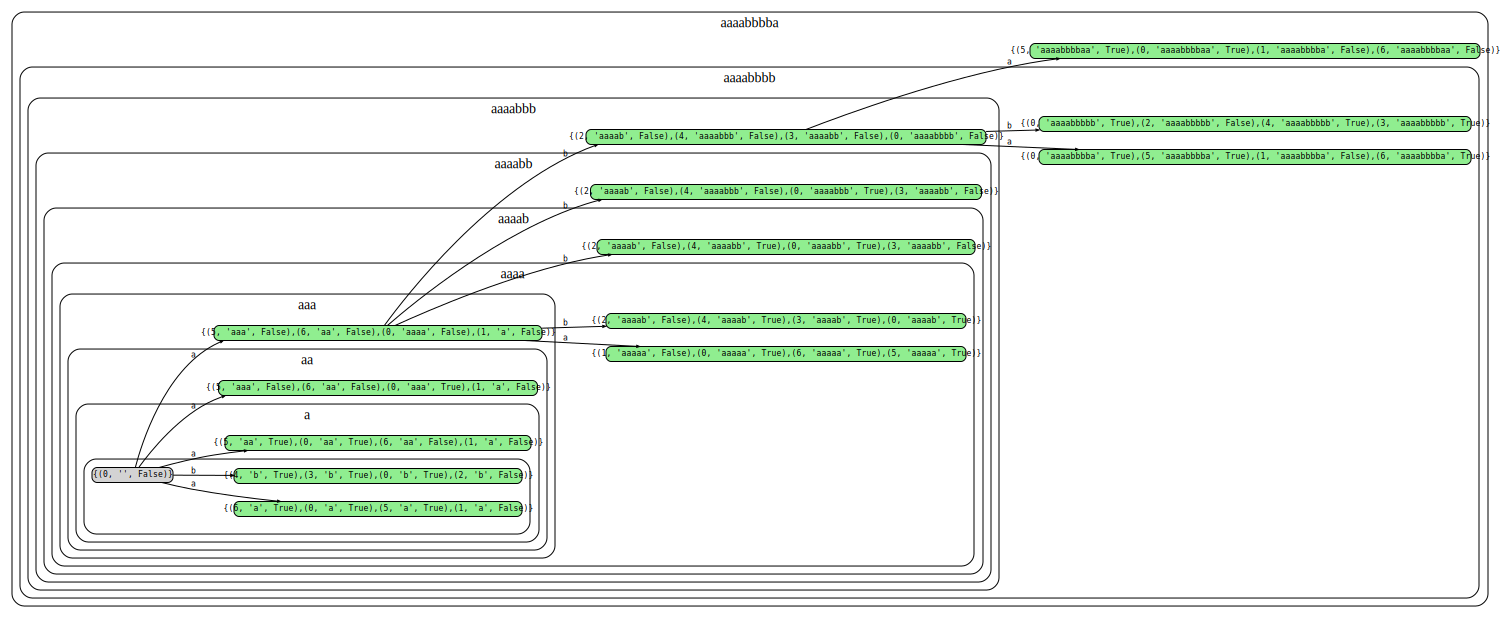

In [162]:
fst = duplicate({'a', 'b'}, 4)
Peekaboo(fst).graphviz('aaaabbbba')

In [163]:
Precover(fst, 'aaaabbbba').show_decomposition()

### Triples of doom

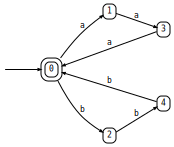

In [164]:
p = examples.triplets_of_doom()
p

In [165]:
list(p.relation(5))

[('', ''), ('aaa', 'aaa'), ('bbb', 'bbb')]

In [166]:
#p = examples.weird_copy()
#Peekaboo(p).graphviz('aaa')

''


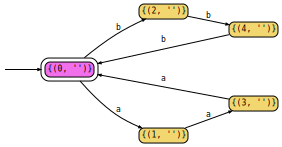

'a'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(3, '')}
├─ remove: {(1, '')}
├─ remove: {(4, '')}
├─ remove: {(2, '')}
├─ add:    {(2, 'a')}
├─ add:    {(4, 'a')}
├─ add:    {(3, 'a')}
├─ add:    {(1, 'a')}
├─ add:    {(0, 'a')}
├─ copy:   {(0, '')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(0, 'a')}, 'a', {(1, 'a')})
├─ add:    ({(1, 'a')}, 'a', {(3, 'a')})
├─ add:    ({(3, 'a')}, 'a', {(0, 'a')})
├─ add:    ({(0, 'a')}, 'b', {(2, 'a')})
├─ add:    ({(0, '')}, 'a', {(1, 'a')})
├─ add:    ({(4, 'a')}, 'b', {(0, 'a')})
├─ add:    ({(2, 'a')}, 'b', {(4, 'a')})


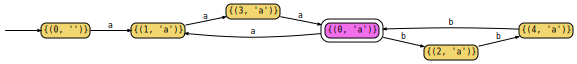

'aa'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(4, 'a')}
├─ remove: {(0, 'a')}
├─ remove: {(2, 'a')}
├─ remove: {(3, 'a')}
├─ add:    {(1, 'aa')}
├─ add:    {(0, 'aa')}
├─ add:    {(2, 'aa')}
├─ add:    {(4, 'aa')}
├─ add:    {(3, 'aa')}
├─ copy:   {(0, '')}
├─ copy:   {(1, 'a')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(0, 'aa')}, 'a', {(1, 'aa')})
├─ add:    ({(1, 'aa')}, 'a', {(3, 'aa')})
├─ add:    ({(1, 'a')}, 'a', {(3, 'aa')})
├─ add:    ({(0, 'aa')}, 'b', {(2, 'aa')})
├─ add:    ({(4, 'aa')}, 'b', {(0, 'aa')})
├─ add:    ({(2, 'aa')}, 'b', {(4, 'aa')})
├─ add:    ({(3, 'aa')}, 'a', {(0, 'aa')})
├─ copy:   ({(0, '')}, 'a', {(1, 'a')})


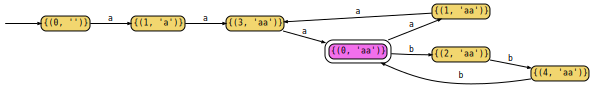

'aaa'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(4, 'aa')}
├─ remove: {(1, 'aa')}
├─ remove: {(2, 'aa')}
├─ remove: {(0, 'aa')}
├─ add:    {(3, 'aaa')}
├─ add:    {(2, 'aaa')}
├─ add:    {(0, 'aaa')}
├─ add:    {(1, 'aaa')}
├─ add:    {(4, 'aaa')}
├─ copy:   {(0, '')}
├─ copy:   {(3, 'aa')}
├─ copy:   {(1, 'a')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(3, 'aaa')}, 'a', {(0, 'aaa')})
├─ add:    ({(3, 'aa')}, 'a', {(0, 'aaa')})
├─ add:    ({(2, 'aaa')}, 'b', {(4, 'aaa')})
├─ add:    ({(0, 'aaa')}, 'a', {(1, 'aaa')})
├─ add:    ({(1, 'aaa')}, 'a', {(3, 'aaa')})
├─ add:    ({(0, 'aaa')}, 'b', {(2, 'aaa')})
├─ add:    ({(4, 'aaa')}, 'b', {(0, 'aaa')})
├─ copy:   ({(1, 'a')}, 'a', {(3, 'aa')})
├─ copy:   ({(0, '')}, 'a', {(1, 'a')})


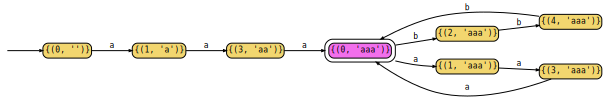

'aaab'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(3, 'aaa')}
├─ remove: {(4, 'aaa')}
├─ remove: {(2, 'aaa')}
├─ remove: {(1, 'aaa')}
├─ add:    {(4, 'aaab')}
├─ add:    {(1, 'aaab')}
├─ add:    {(0, 'aaab')}
├─ add:    {(2, 'aaab')}
├─ add:    {(3, 'aaab')}
├─ copy:   {(0, '')}
├─ copy:   {(3, 'aa')}
├─ copy:   {(0, 'aaa')}
├─ copy:   {(1, 'a')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(0, 'aaa')}, 'b', {(2, 'aaab')})
├─ add:    ({(2, 'aaab')}, 'b', {(4, 'aaab')})
├─ add:    ({(1, 'aaab')}, 'a', {(3, 'aaab')})
├─ add:    ({(3, 'aaab')}, 'a', {(0, 'aaab')})
├─ add:    ({(0, 'aaab')}, 'b', {(2, 'aaab')})
├─ add:    ({(4, 'aaab')}, 'b', {(0, 'aaab')})
├─ add:    ({(0, 'aaab')}, 'a', {(1, 'aaab')})
├─ copy:   ({(1, 'a')}, 'a', {(3, 'aa')})
├─ copy:   ({(0, '')}, 'a', {(1, 'a')})
├─ copy:   ({(3, 'aa')}, 'a', {(0, 'aaa')})


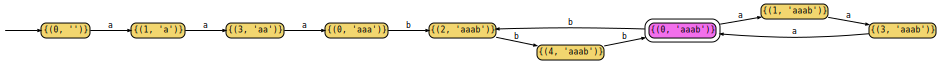

In [167]:
rollout(p, 'aaab')

'aaab'
'aaa'
'aa'
'a'
''


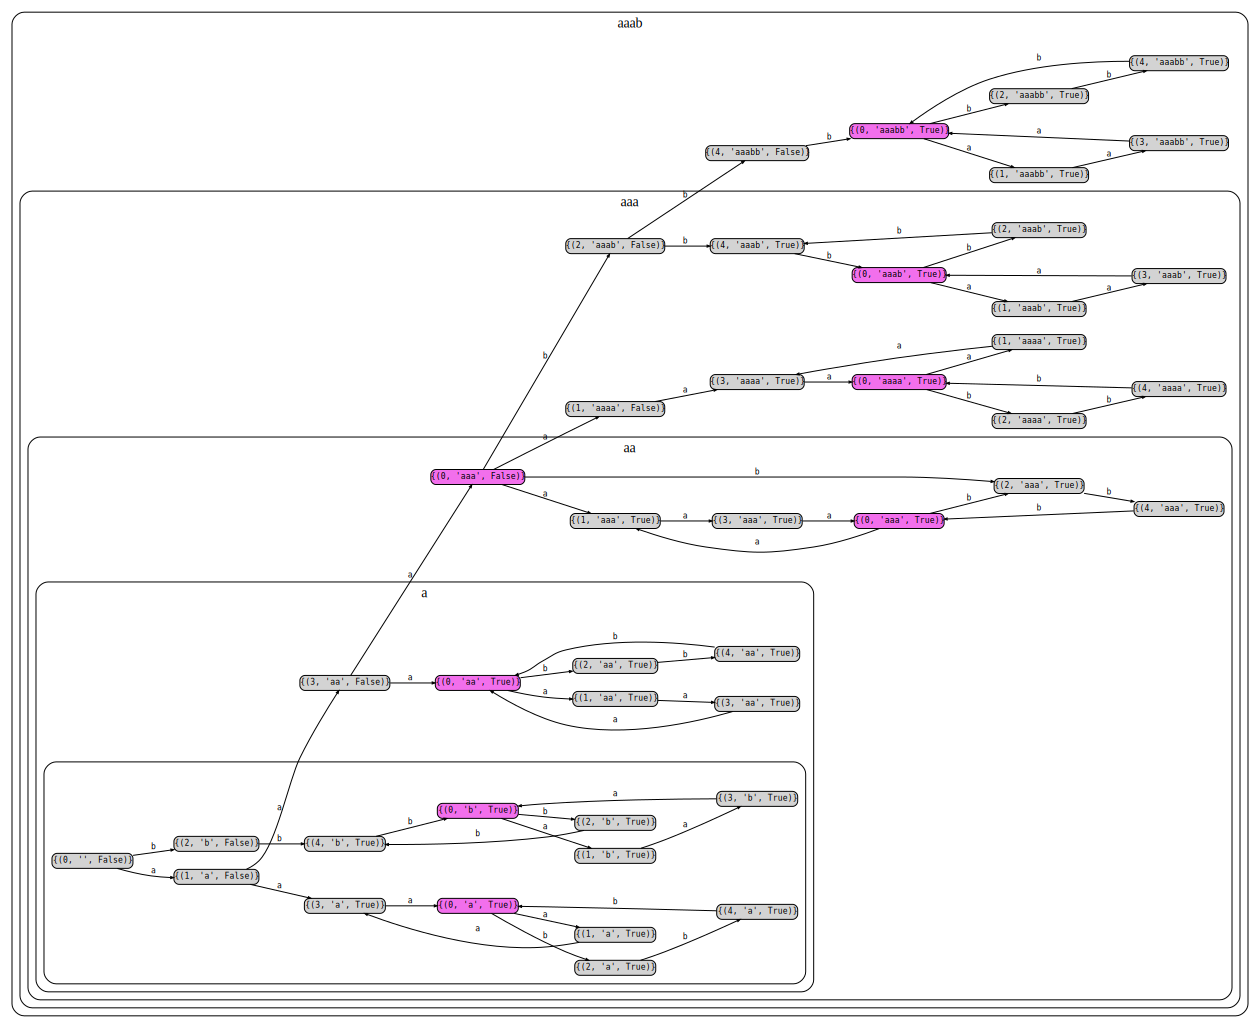

In [168]:
Peekaboo(p).graphviz('aaab')

### Small

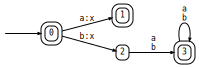

In [169]:
fst = examples.small()
fst

In [170]:
Peekaboo(fst).check('')

✔ sym: 'a'
✔ sym: 'x'
✔ sym: 'b'


'xab'
'xa'
'x'
''


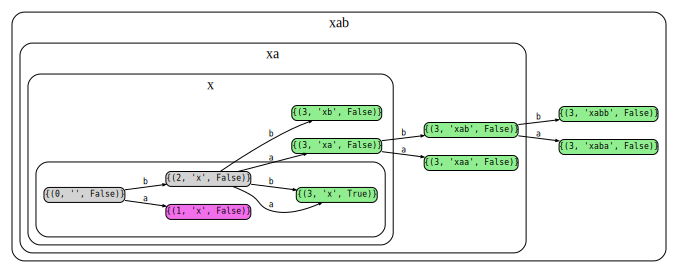

In [171]:
Peekaboo(fst).graphviz('xab')

''


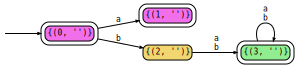

'x'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(3, '')}
├─ remove: {(1, '')}
├─ remove: {(2, '')}
├─ add:    {(3, 'x')}
├─ add:    {(1, 'x')}
├─ add:    {(2, 'x')}
├─ copy:   {(0, '')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(2, 'x')}, 'a', {(3, 'x')})
├─ add:    ({(2, 'x')}, 'b', {(3, 'x')})
├─ add:    ({(0, '')}, 'a', {(1, 'x')})
├─ add:    ({(0, '')}, 'b', {(2, 'x')})


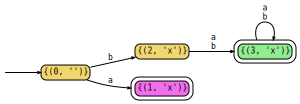

'xa'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(3, 'x')}
├─ add:    {(3, 'xa')}
├─ copy:   {(0, '')}
├─ copy:   {(1, 'x')}
├─ copy:   {(2, 'x')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(2, 'x')}, 'a', {(3, 'xa')})
├─ copy:   ({(0, '')}, 'a', {(1, 'x')})
├─ copy:   ({(0, '')}, 'b', {(2, 'x')})


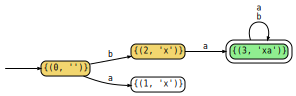

'xab'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ add:    {(3, 'xab')}
├─ copy:   {(0, '')}
├─ copy:   {(1, 'x')}
├─ copy:   {(2, 'x')}
├─ copy:   {(3, 'xa')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(3, 'xa')}, 'b', {(3, 'xab')})
├─ copy:   ({(0, '')}, 'a', {(1, 'x')})
├─ copy:   ({(2, 'x')}, 'a', {(3, 'xa')})
├─ copy:   ({(0, '')}, 'b', {(2, 'x')})


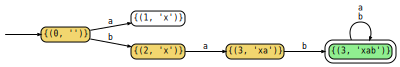

In [172]:
rollout(fst, 'xab')

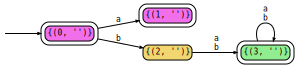

In [173]:
Precover(fst, '')

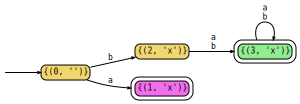

In [174]:
Precover(fst, 'x')

In [175]:
Precover(fst, 'x').show_decomposition()

quotient,remainder
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 1 <!-- start->0 --> start->0 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 b <!-- 1 --> 1 0 <!-- 2->1 --> 2->1 a b","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 2 <!-- start->0 --> start->0 <!-- 1 --> 1 0 <!-- 0->1 --> 0->1 a"


### Lookahead

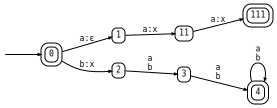

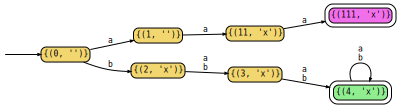

In [177]:
fst = examples.lookahead()
display(fst)
P = Precover(fst, 'x')
display(P)
P.show_decomposition(minimize=False)

'xab'
'xa'
'x'
''


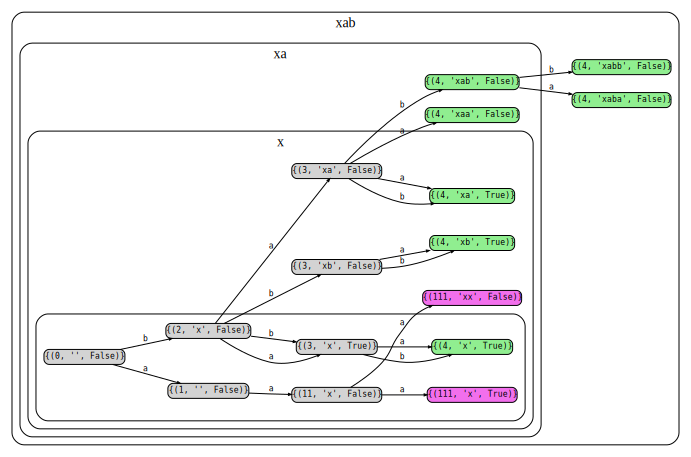

In [178]:
Peekaboo(fst).graphviz('xab')

'xx'
'x'
''


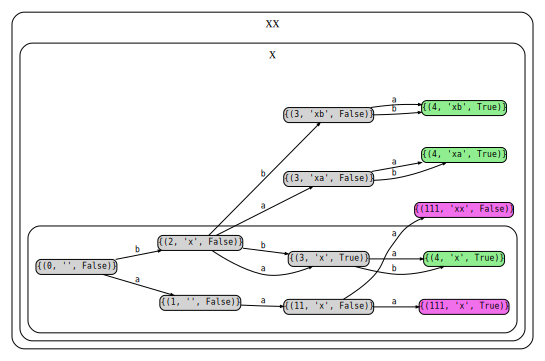

In [179]:
Peekaboo(fst).graphviz('xx')